# 🧠 Breast Cancer Detection with MobileNetV2
Ce notebook entraîne un modèle MobileNetV2 pour détecter des images échographiques du sein : bénignes, malignes ou normales.

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shutil

## 📁 Chargement et Préparation des données

In [2]:
base_dir = "C:/Users/Souad.ABOUD/Documents/LAB/breast-cancer-detector_Projet2/Dataset_BUSI_with_GT"

img_size = (224, 224)
batch_size = 16

# Data augmentation + rescaling pour train et val
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen_val = ImageDataGenerator(preprocessing_function=preprocess_input)

# Générateur train
train_generator = datagen_train.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)

# Générateur val
val_generator = datagen_val.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)

# Générateur test - uniquement rescaling, pas d'augmentation
datagen_test = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = datagen_test.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1578 images belonging to 3 classes.
Found 1578 images belonging to 3 classes.
Found 1578 images belonging to 3 classes.


In [3]:
# 🧠 Création du modèle MobileNetV2 (idem que ton code)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
# ⚙️ Compilation et Entraînement
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

c:\Users\Souad.ABOUD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 56s 535ms/step - accuracy: 0.5296 - loss: 1.1493 - val_accuracy: 0.7991 - val_loss: 0.4736
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 53s 541ms/step - accuracy: 0.7483 - loss: 0.5842 - val_accuracy: 0.8302 - val_loss: 0.4111
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 54s 542ms/step - accuracy: 0.7799 - loss: 0.5336 - val_accuracy: 0.8390 - val_loss: 0.3771
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 53s 536ms/step - accuracy: 0.8144 - loss: 0.4234 - val_accuracy: 0.8504 - val_loss: 0.3488
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 52s 531ms/step - accuracy: 0.7811 - loss: 0.4784 - val_accuracy: 0.8650 - val_loss: 0.3309
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 54s 548ms/step - accuracy: 0.8226 - loss: 0.4141 - val_accuracy: 0.8657 - val_loss: 0.3336
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 53s 532ms/step - accuracy: 0.8195 - loss: 0.3999 - val_accuracy: 0.8682 - val_loss: 0.3204
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 53s 540ms/step - accuracy: 0.8459 - loss: 0.3782 - val_accu

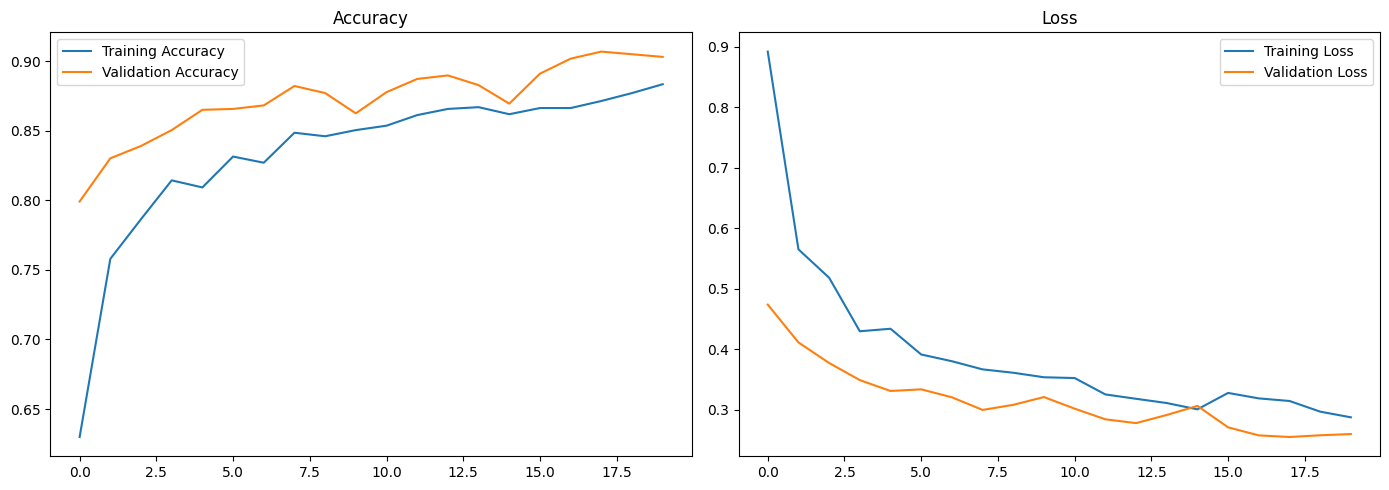

In [5]:
# 📊 Courbes d'apprentissage (ta fonction existante)
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

In [6]:
# 📁 Sauvegarde du modèle entraîné
model_save_path = "C:/Users/Souad.ABOUD/Documents/LAB/breast-cancer-detector_Projet2/model/breast_cancer_model.h5"
model.save(model_save_path)
print("✅ Modèle sauvegardé avec succès.")

# 🔄 Chargement du modèle entraîné
model = load_model(model_save_path)
print("✅ Modèle chargé avec succès.")

✅ Modèle sauvegardé avec succès.


✅ Modèle chargé avec succès.


In [7]:
# 🔁 ÉVALUATION SUR LE JEU DE TEST
class_indices = train_generator.class_indices
labels = dict((v, k) for k, v in class_indices.items())

loss, accuracy = model.evaluate(test_generator)
print('\n📊 Évaluation sur le jeu de test :')
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

y_true = test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

print("\n📄 Rapport de classification (test set) :")
print(classification_report(y_true, y_pred, target_names=labels.values()))

print("\n📌 Matrice de confusion brute (test set) :")
print(confusion_matrix(y_true, y_pred))

99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 213ms/step - accuracy: 0.9149 - loss: 0.2301

📊 Évaluation sur le jeu de test :
Loss: 0.2597
Accuracy: 0.9030
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 223ms/step

📄 Rapport de classification (test set) :
              precision    recall  f1-score   support

      benign       0.94      0.91      0.93       891
   malignant       0.80      0.92      0.86       421
      normal       0.95      0.85      0.90       266

    accuracy                           0.90      1578
   macro avg       0.90      0.89      0.89      1578
weighted avg       0.91      0.90      0.90      1578


📌 Matrice de confusion brute (test set) :
[[813  71   7]
 [ 30 387   4]
 [ 18  23 225]]


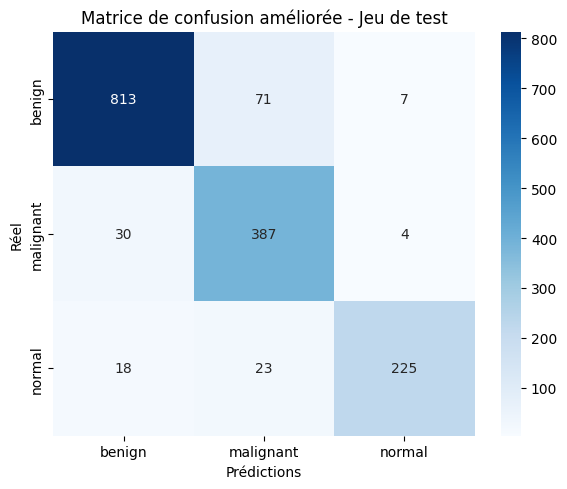

In [8]:
# 📈 Matrice de confusion améliorée (test set)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels.values(),
            yticklabels=labels.values())
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.title('Matrice de confusion améliorée - Jeu de test')
plt.tight_layout()
plt.show()


Epoch 1/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 59s 564ms/step - accuracy: 0.8840 - loss: 0.2755 - val_accuracy: 0.8999 - val_loss: 0.2593
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 54s 549ms/step - accuracy: 0.8736 - loss: 0.3102 - val_accuracy: 0.8973 - val_loss: 0.2650
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 55s 553ms/step - accuracy: 0.8896 - loss: 0.2764 - val_accuracy: 0.9024 - val_loss: 0.2601
Epoch 4/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 54s 545ms/step - accuracy: 0.8962 - loss: 0.2592 - val_accuracy: 0.8999 - val_loss: 0.2570
Epoch 5/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 55s 559ms/step - accuracy: 0.8785 - loss: 0.2985 - val_accuracy: 0.8980 - val_loss: 0.2603


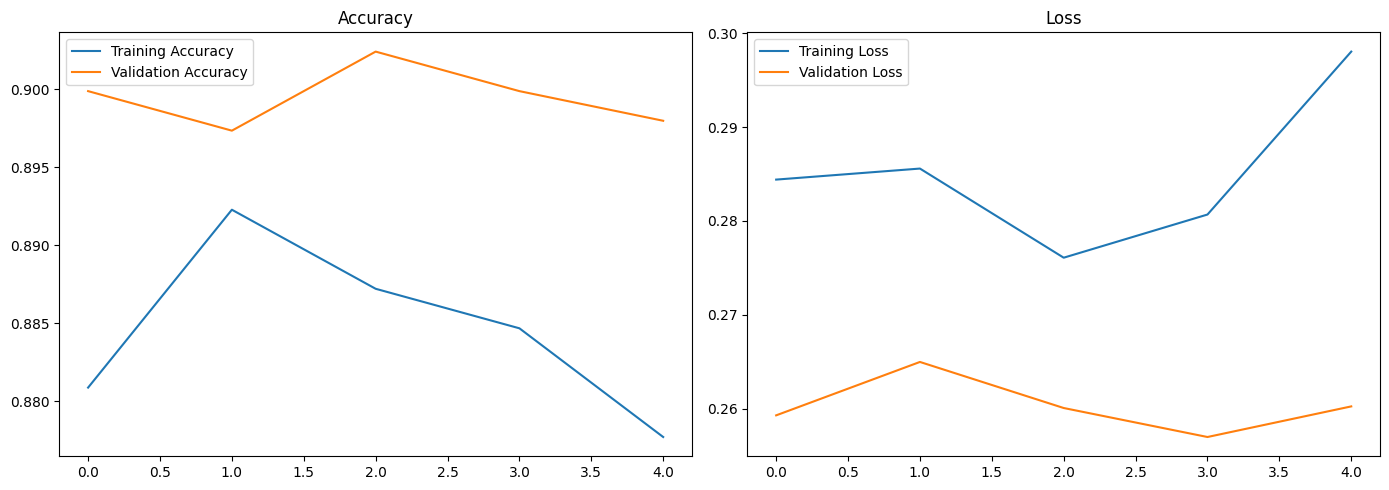

In [9]:
# 🎯 Suggestions déjà présentes dans ton code pour fine-tuning etc (optionnel)

# --- Fine-tuning (idem ton code) ---
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

plot_learning_curve(fine_tune_history)

model.save("fine_tuned_model.keras")

In [10]:
# --- Sauvegarde images mal classées (sur test set) ---
misclassified_dir = "misclassified"
if os.path.exists(misclassified_dir):
    shutil.rmtree(misclassified_dir)
os.makedirs(misclassified_dir)

file_paths = test_generator.filepaths

for i in range(len(y_true)):
    if y_pred[i] != y_true[i]:
        src_path = file_paths[i]
        true_label = labels[y_true[i]]
        pred_label = labels[y_pred[i]]
        filename = os.path.basename(src_path).replace(" ", "_")
        dst_path = os.path.join(misclassified_dir, f"{filename}_true_{true_label}_pred_{pred_label}.jpg")
        shutil.copy(src_path, dst_path)

print(f"\n✅ Images mal classées sauvegardées dans '{misclassified_dir}'")


✅ Images mal classées sauvegardées dans 'misclassified'


In [11]:
# --- PARTIE AJOUTÉE POUR TESTS ET AMÉLIORATIONS ---

print("\n🚀 Début des tests complémentaires et améliorations...")


from sklearn.model_selection import train_test_split

# 🔁 Récupération de toutes les images du dossier 'test'
strict_test_dir = os.path.join(base_dir, "test")
strict_file_paths = []
strict_labels = []

for class_name in os.listdir(strict_test_dir):
    class_path = os.path.join(strict_test_dir, class_name)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                strict_file_paths.append(os.path.join(class_path, file))
                strict_labels.append(class_name)


🚀 Début des tests complémentaires et améliorations...


In [12]:
# 🧹 Nettoyage & tri des labels
strict_file_paths = np.array(strict_file_paths)
strict_labels = np.array(strict_labels)
labels_set = sorted(list(set(strict_labels)))

In [14]:
# 📂 Split stratifié (80% éval intermédiaire, 20% test strict)
_, strict_paths, _, strict_y = train_test_split(
    strict_file_paths, strict_labels,
    test_size=0.2,  # corrigé ici
    stratify=strict_labels, random_state=42
)

print(f"✅ Jeu test strict préparé ({len(strict_paths)} images)")


✅ Jeu test strict préparé (316 images)


In [15]:
# 🔁 Générateur personnalisé pour le jeu test strict
def strict_generator(paths, labels, batch_size=16, target_size=(224, 224)):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            images = []
            targets = []
            for p, l in zip(batch_paths, batch_labels):
                img = image.load_img(p, target_size=target_size)
                img = image.img_to_array(img)
                img = preprocess_input(img)  # MobileNetV2 preprocessing
                images.append(img)
                onehot = np.zeros(len(labels_set))
                onehot[labels_set.index(l)] = 1
                targets.append(onehot)
            yield (np.array(images), np.array(targets))

steps = len(strict_paths) // batch_size
if len(strict_paths) % batch_size != 0:
    steps += 1

gen_strict = strict_generator(strict_paths, strict_y, batch_size=batch_size)


In [16]:
# 🧪 Évaluation
loss, acc = model.evaluate(gen_strict, steps=steps)
print(f"\n📊 Évaluation sur test strict :")
print(f"Loss : {loss:.4f}")
print(f"Accuracy : {acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 252ms/step - accuracy: 0.8877 - loss: 0.2568

📊 Évaluation sur test strict :
Loss : 0.2751
Accuracy : 0.8924


In [17]:
# 📈 Prédictions détaillées
y_true = []
y_pred = []

for i in range(steps):
    X_batch, y_batch = next(gen_strict)
    preds = model.predict(X_batch)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


In [18]:
# 📄 Rapport de classification
from sklearn.metrics import classification_report, confusion_matrix
print("\n📄 Rapport de classification (test strict) :")
print(classification_report(y_true, y_pred, target_names=labels_set))



📄 Rapport de classification (test strict) :
              precision    recall  f1-score   support

      benign       0.93      0.91      0.92       179
   malignant       0.79      0.90      0.84        84
      normal       0.96      0.81      0.88        53

    accuracy                           0.89       316
   macro avg       0.89      0.88      0.88       316
weighted avg       0.90      0.89      0.89       316



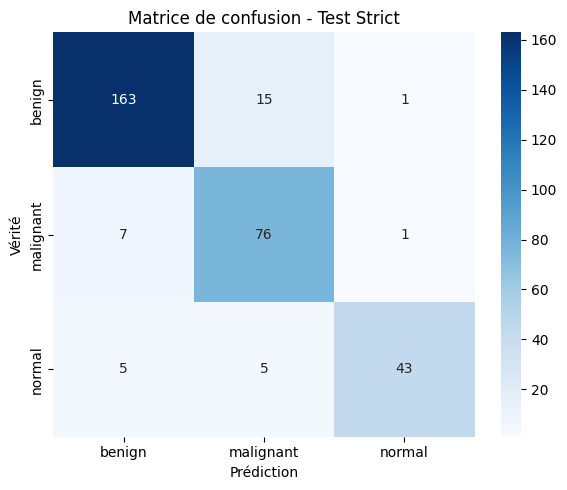

In [19]:
# 🔷 Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_set,
            yticklabels=labels_set)
plt.xlabel("Prédiction")
plt.ylabel("Vérité")
plt.title("Matrice de confusion - Test Strict")
plt.tight_layout()
plt.show()